In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from tqdm.notebook import tqdm, trange
from scipy import ndimage

import os

In [ ]:
with open('letters.png', 'rb') as infile:
     buf = infile.read()
x = np.fromstring(buf, dtype='uint8')
img = cv2.imdecode(x, cv2.IMREAD_UNCHANGED)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def get_steps(step = 1, m = 50):
    return list(np.arange(1, m, step)) + list(-1 * np.arange(1, m, step))

def check_mask(mask, x, y, pad_x, pad_y, size_x, size_y ,s):
    return np.sum(mask[int(pad_x + s * x + size_x * x): int(pad_x + s * x + size_x * (x + 1)),
                       int(pad_y + s * y + size_y * y): int(pad_y + s * y + size_y * (y + 1))]) == 0

def get_img(img, x, y, pad_x, pad_y, size_x, size_y, s):
    temp_img =  img[int(pad_x + s * x + size_x * x): int(pad_x + s * x + size_x * (x + 1)),
                        int(pad_y + s * y + size_y * y): int(pad_y + s * y + size_y * (y + 1)),
                       :]
    
    d = np.zeros((size_x , size_y ,temp_img.shape[2]), dtype=np.uint8)
    d[:,:,:] = 255
    d[:temp_img.shape[0],:temp_img.shape[1],:temp_img.shape[2]] = temp_img
    return d, cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)

def get_crop_img(img, x, y, pad_x, pad_y, mask, size_x = 76, size_y = 76, step = 1, s=13):
    
    temp_img, temp_img_2 = get_img(img, x, y, pad_x, pad_y, size_x, size_y,s)

    # dov_int = 20 + 1
    # s = 0
    
    if len(set(temp_img_2[:, size_y - 1])) != 1 or len(set(temp_img_2[:, 0])) != 1 or not check_mask(mask, x, y, pad_x, pad_y, size_x, size_y,s):
        for i in sorted(get_steps(), key = abs):
            temp_pad_y = pad_y + i
            if temp_pad_y < 0:
                temp_pad_y = 0
            if pad_y > (9999 + size_y):
                temp_pad_y = pad_y
            temp_img, temp_img_3 = get_img(img, x, y, pad_x, temp_pad_y, size_x, size_y,s)
            if (check_mask(mask, x, y, pad_x, temp_pad_y, size_x, size_y,s) and (len(set(temp_img_3[:, size_y - 1])) == 1 or  int(pad_y + s * y + size_y * (y + 1)) == 9999) and (len(set(temp_img_3[:, 0]))  == 1 or int(pad_y + s * y + size_y * y) == 0)):
                pad_y = temp_pad_y
                break
    if len(set(temp_img_2[size_x - 1, :])) != 1 or len(set(temp_img_2[0, :])) != 1 or not check_mask(mask, x, y, pad_x, pad_y, size_x, size_y,s):
        for i in sorted(get_steps(), key = abs):
            
            temp_pad_x = pad_x + i
            if temp_pad_x < 0:
                temp_pad_x = 0
            if pad_x > (9999 + size_x):
                temp_pad_x = pad_x
            temp_img, temp_img_3 = get_img(img, x, y, temp_pad_x, pad_y, size_x, size_y,s)
            if (check_mask(mask, x, y, temp_pad_x, pad_y, size_x, size_y,s)   and (len(set(temp_img_3[size_x - 1, :])) == 1 or  int(pad_x + s * x + size_x * (x + 1)) == 9999) and (len(set(temp_img_3[0, :]))  == 1 or int(pad_x + s * x + size_x * x) == 0)):
                pad_x = temp_pad_x
                break
        
    
    temp_img, temp_img_2 = get_img(img, x, y, pad_x, pad_y, size_x, size_y,s)

    mask[int(pad_x + s * x + size_x * x): int(pad_x + s * x + size_x * (x + 1)),
         int(pad_y + s * y + size_y * y): int(pad_y + s * y + size_y * (y + 1))] += 120

    rotated = ndimage.rotate(temp_img, ((-x + y +  97 - 50) / (97 - 25) * 360))
    rotated[np.where(rotated == 0)] = 255
    sized = crop_img(rotated, size_x, size_y)
    # sized = rotated[int(rotated.shape[0] / 2 - size_x / 2): int(rotated.shape[0] / 2 - size_x / 2) + size_x, 
    #                 int(rotated.shape[1] / 2 - size_y / 2): int(rotated.shape[1] / 2 - size_y / 2) + size_y, :]
    # cv2.resize(rotated, (size_x, size_y), cv2.INTER_NEAREST)

    cv2.imwrite(os.path.join(f_name, f"img_{x}_{y}.png"), temp_img)
    cv2.imwrite(os.path.join(f_name_r, f"img_r_{x}_{y}.png"), sized)

    return temp_img, rotated, sized, pad_x, pad_y, mask

def crop_img(img_r, size_x, size_y):
    img = cv2.cvtColor(img_r, cv2.COLOR_BGR2GRAY)
    while img.shape[0] > size_x:
        # print(img.shape)
        if len(set(img[0, :])) < len(set(img[img.shape[0] -1, :])):
            img_r = img_r[1:, :]
            img = img[1:, :]
        else:
            img_r = img_r[:img.shape[0]-1, :]
            img = img[:img.shape[0]-1, :]
    while img.shape[1] > size_y:
        # print(img.shape)
        if len(set(img[:, 0])) < len(set(img[:,img.shape[1] -1])):
            img_r = img_r[:,1:]
            img = img[:,1:]
            
        else:
            img_r = img_r[:, :img_r.shape[1] - 1]
            img = img[:, :img.shape[1] - 1]
            
    return img_r
    
    

In [ ]:
pad_x = 0
pad_y = 34

pad_xs = np.zeros(img.shape[:2])
pad_ys = np.zeros(img.shape[:2])

mask = np.zeros(img.shape[:2])
pad_ys[0,0] = 34

imgs = {}
r_imgs = {}
s_imgs = {}

f_name = "imgs"
f_name_r = "imgs_rotated"

if not os.path.exists(f_name):
    os.mkdir(f_name)
if not os.path.exists(f_name_r):
    os.mkdir(f_name_r)

for i in trange(116):
    for j in range(116):

        x = i 
        y = j
        pad_y = 34# + (pad_ys[x-1,y] + pad_ys[x, y-1])/ 2
        pad_x = pad_xs[x-1,y] #+ pad_xs[x, y-1])/ 2

        temp_img, rotated,sized, pad_x, pad_y, mask = get_crop_img(img, x, y, pad_x, pad_y, mask, s = 16, size_x = 70, size_y = 70)

        imgs[(x,y)] = temp_img
        r_imgs[(x,y)] = rotated
        s_imgs[(x,y)] = sized
        pad_xs[x,y] = pad_x
        pad_ys[x,y] = pad_y


  0%|          | 0/116 [00:00<?, ?it/s]

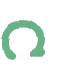

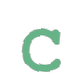

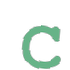

In [ ]:
x = 0
y = 114
cv2_imshow(imgs[x,y])
cv2_imshow(r_imgs[x,y])
cv2_imshow(s_imgs[x,y])

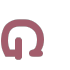

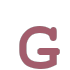

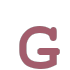

In [ ]:
x = 0
y = 115
cv2_imshow(imgs[x,y])
cv2_imshow(r_imgs[x,y])
cv2_imshow(s_imgs[x,y])

In [ ]:
cv2_imshow(mask)

- 0


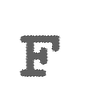

- 1


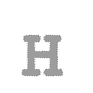

- 2


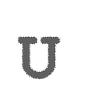

- 3


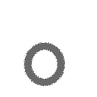

- 4


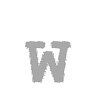

- 5


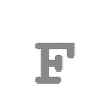

- 6


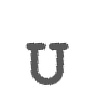

- 7


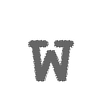

- 8


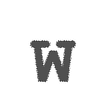

- 9


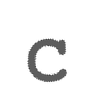

- 10


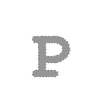

- 11


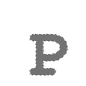

- 12


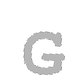

- 13


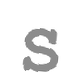

- 14


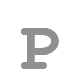

- 15


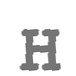

- 16


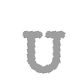

- 17


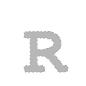

- 18


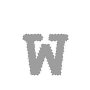

- 19


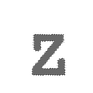

- 20


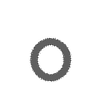

- 21


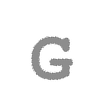

- 22


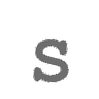

- 23


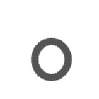

- 24


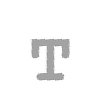

- 25


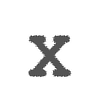

- 26


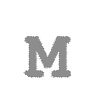

- 27


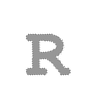

- 28


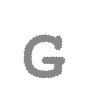

- 29


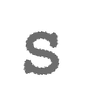

- 30


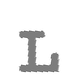

- 31


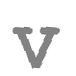

- 32


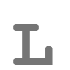

- 33


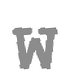

- 34


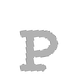

- 35


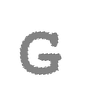

- 36


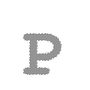

- 37


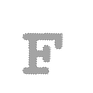

- 38


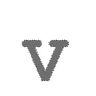

- 39


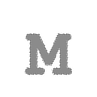

- 40


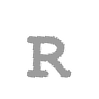

- 41


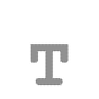

- 42


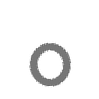

- 43


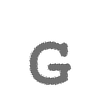

- 44


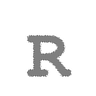

- 45


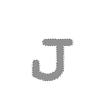

- 46


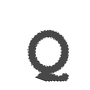

- 47


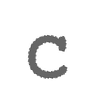

- 48


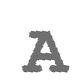

- 49


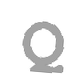

- 50


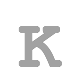

- 51


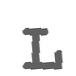

- 52


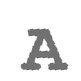

- 53


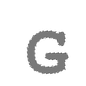

- 54


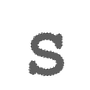

- 55


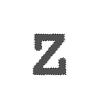

- 56


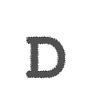

- 57


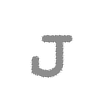

- 58


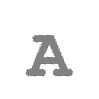

- 59


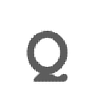

- 60


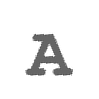

- 61


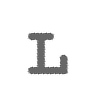

- 62


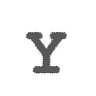

- 63


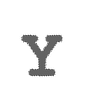

- 64


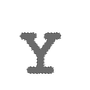

- 65


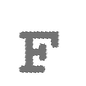

- 66


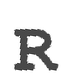

- 67


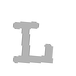

- 68


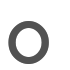

- 69


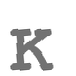

- 70


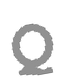

- 71


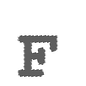

- 72


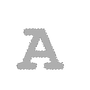

- 73


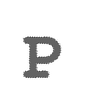

- 74


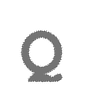

- 75


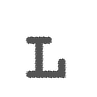

- 76


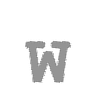

- 77


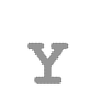

- 78


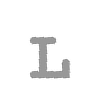

- 79


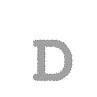

- 80


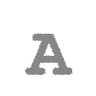

- 81


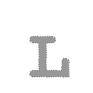

- 82


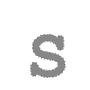

- 83


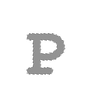

- 84


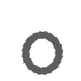

- 85


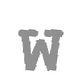

- 86


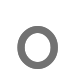

- 87


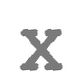

- 88


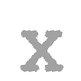

- 89


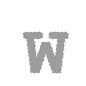

- 90


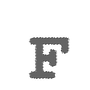

- 91


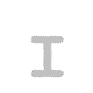

- 92


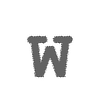

- 93


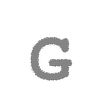

- 94


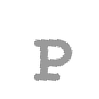

- 95


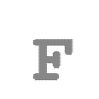

- 96


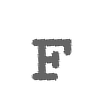

- 97


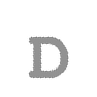

- 98


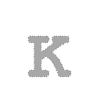

- 99


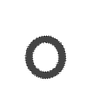

- 100


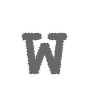

- 101


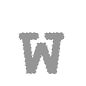

- 102


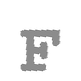

- 103


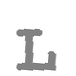

- 104


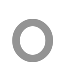

- 105


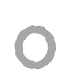

- 106


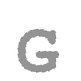

- 107


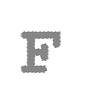

- 108


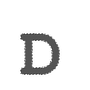

- 109


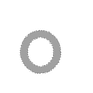

- 110


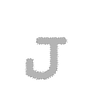

- 111


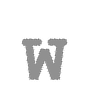

- 112


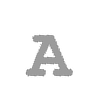

- 113


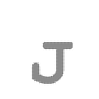

- 114


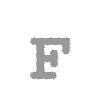

- 115


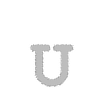

In [ ]:
for i in range(116):
    print("-", i)
    cv2_imshow(cv2.cvtColor(r_imgs[115,i], cv2.COLOR_BGR2GRAY))
    

In [ ]:
!zip -r imgs.zip imgs
!zip -r imgs_r.zip imgs_rotated

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: imgs_rotated/img_r_7_46.png (deflated 2%)
  adding: imgs_rotated/img_r_10_73.png (deflated 2%)
  adding: imgs_rotated/img_r_30_80.png (deflated 2%)
  adding: imgs_rotated/img_r_83_85.png (deflated 3%)
  adding: imgs_rotated/img_r_13_57.png (deflated 2%)
  adding: imgs_rotated/img_r_61_109.png (deflated 2%)
  adding: imgs_rotated/img_r_23_47.png (deflated 2%)
  adding: imgs_rotated/img_r_110_24.png (deflated 3%)
  adding: imgs_rotated/img_r_12_56.png (deflated 2%)
  adding: imgs_rotated/img_r_53_103.png (deflated 2%)
  adding: imgs_rotated/img_r_4_14.png (deflated 2%)
  adding: imgs_rotated/img_r_109_70.png (deflated 2%)
  adding: imgs_rotated/img_r_93_53.png (deflated 2%)
  adding: imgs_rotated/img_r_84_17.png (deflated 2%)
  adding: imgs_rotated/img_r_88_52.png (deflated 2%)
  adding: imgs_rotated/img_r_9_63.png (deflated 2%)
  adding: imgs_rotated/img_r_31_8.png (deflated 2%)
  adding: imgs_rotated/img_r_61